![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FFramework+Workflows%2FKeras&file=Keras+Overview.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Framework%20Workflows/Keras/Keras%20Overview.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FFramework%2520Workflows%2FKeras%2FKeras%2520Overview.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Framework%20Workflows/Keras/Keras%20Overview.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Framework%20Workflows/Keras/Keras%20Overview.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Keras Overview

An overview of using Keras 3 for building an autoencoder and its application in anomaly detection.

Neural Networks provide a powerful and flexible framework for learning complex patterns in data. They represent data with general structures called tensors and learn by iteratively adjusting internal parameters through a process called training. This allows them to build sophisticated representations of the underlying data distribution.

**Structure and Training:**

A neural network is structured as a series of interconnected layers. Each layer is composed of nodes (or neurons) connected to the nodes in preceding and subsequent layers. During training, the network learns optimal values for these connections (weights) and biases associated with each node, enabling it to map inputs to desired outputs.

**Frameworks and Keras:**

Several popular frameworks facilitate neural network development, including TensorFlow, PyTorch, and the increasingly adopted JAX. Keras 3 offers a user-friendly, high-level API that sits atop these frameworks, enabling you to build and train models that can leverage the strengths of each backend. This means you can write your code once in Keras and potentially switch the backend (TensorFlow, PyTorch, or JAX) depending on your needs or performance considerations.

**Autoencoders and Anomaly Detection:**

Autoencoders are a specific type of neural network architecture that learn to reconstruct their input data. By forcing the network to learn a compressed representation of the data (encoding) and then reconstruct it (decoding), autoencoders can capture essential features. This makes them useful for tasks like dimensionality reduction and, importantly, anomaly detection. Anomalies, being significantly different from the learned patterns, typically result in higher reconstruction errors, allowing for their identification.

**What This Workflow Covers:**
- Train an autoencoder with Keras API
    - Use Tensorflow Dataset to manage reading data
    - Format data for training
    - Preprocess data for training with feature engineering steps
    - Train the model
    - Evaluate the model
    - Predict with the model
- Enhance the autoencoder:
    - include preprocessing within the model
    - name the model inputs to help with training/serving skew
    - customize the model outputs
    - export and import the model for serving

---
## Colab Setup

When running this notebook in [Colab](https://colab.google/) or [Colab Enterprise](https://cloud.google.com/colab/docs/introduction), this section will authenticate to GCP (follow prompts in the popup) and set the current project for the session.

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment. 

### Installs (If Needed)

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.bigquery', 'google-cloud-bigquery'),
    ('jax','jax'),
    ('keras', 'keras', '3.6.0'),
    ('tensorflow', 'tensorflow'),
    ('pydot', 'pydot')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### Graphviz Install

Plotting the [model structure with Keras](https://keras.io/api/utils/model_plotting_utils/) uses [Graphviz](https://graphviz.org/download/).

This code checks for Graphviz and if missing installs it.

In [4]:
check = !dot -V
if check[0].startswith('dot'):
    print(f'Graphviz installed with version: {check[0]}')
else:
    print('Installing Graphviz...')
    install = !sudo apt-get install graphviz --assume-yes
    print('Completed')

Graphviz installed with version: dot - graphviz version 2.43.0 (0)


### API Enablement

In [5]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [6]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

Inputs

In [7]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [8]:
REGION = 'us-central1'
SERIES = 'frameworks-keras'
EXPERIMENT = 'overview'

# Data source for this series of notebooks: Described above
BQ_SOURCE = 'bigquery-public-data.ml_datasets.ulb_fraud_detection'

# make this the BigQuery Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[0:2] # use a multi region

Packages

In [9]:
# import python package
import os
from collections import OrderedDict

# import keras, set backend prior to first import of keras
os.environ['KERAS_BACKEND'] = 'jax'
import keras

import matplotlib.pyplot as plt

# import jax for numerical operations uses with keras (and jax backend) - like custom loss function
import jax.numpy as jnp

# import tensorflow - used here to read data with tf.data
import tensorflow as tf

# Vertex AI
from google.cloud import aiplatform

# BigQuery
from google.cloud import bigquery

2025-02-05 19:25:05.083113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738783505.114095  663200 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738783505.122389  663200 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Check Versions of Packages:

In [10]:
aiplatform.__version__

'1.78.0'

In [11]:
keras.__version__

'3.6.0'

In [12]:
tf.__version__

'2.18.0'

Clients

In [13]:
# vertex ai clients
aiplatform.init(project = PROJECT_ID, location = REGION)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

---
## Review Source Data

This is a BigQuery public table of 284,807 credit card transactions classified as fradulant or normal in the column `Class`.
- The data can be researched further at this [Kaggle link](https://www.kaggle.com/mlg-ulb/creditcardfraud).
- Read mode about BigQuery public datasets [here](https://cloud.google.com/bigquery/public-data)

In order protect confidentiality, the original features have been transformed using [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) into 28 features named `V1, V2, ... V28` (float).  Two descriptive features are provided without transformation by PCA:
- `Time` (integer) is the seconds elapsed between the transaction and the earliest transaction in the table
- `Amount` (float) is the value of the transaction
 

### Review BigQuery table:

In [14]:
source_data = bq.query(f'SELECT * FROM `{BQ_SOURCE}` LIMIT 5').to_dataframe()
source_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,8748.0,-1.070416,0.304517,2.777064,2.154061,0.254450,-0.448529,-0.398691,0.144672,1.070900,...,-0.122032,-0.182351,0.019576,0.626023,-0.018518,-0.263291,-0.198600,0.098435,0.0,0
1,27074.0,1.165628,0.423671,0.887635,2.740163,-0.338578,-0.142846,-0.055628,-0.015325,-0.213621,...,-0.081184,-0.025694,-0.076609,0.414687,0.631032,0.077322,0.010182,0.019912,0.0,0
2,28292.0,1.050879,0.053408,1.364590,2.666158,-0.378636,1.382032,-0.766202,0.486126,0.152611,...,0.083467,0.624424,-0.157228,-0.240411,0.573061,0.244090,0.063834,0.010981,0.0,0
3,28488.0,1.070316,0.079499,1.471856,2.863786,-0.637887,0.858159,-0.687478,0.344146,0.459561,...,0.048067,0.534713,-0.098645,0.129272,0.543737,0.242724,0.065070,0.023500,0.0,0
4,31392.0,-3.680953,-4.183581,2.642743,4.263802,4.643286,-0.225053,-3.733637,1.273037,0.015661,...,0.649051,1.054124,0.795528,-0.901314,-0.425524,0.511675,0.125419,0.243671,0.0,0


In [15]:
source_data.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       Int64
dtype: object

---
## Prepare Data Source

The data preparation includes adding splits for machine learning with a column named `splits` with 80% for training (`TRAIN`), 10% for validation (`VALIDATE`) and 10% for testing (`TEST`). Additionally, a unique identifier was added to each transaction, `transaction_id`. 

>These steps could be done locally at training but are instead done in the source system, BigQuery in this case, which provides several advantages:
>
>-   **Single Source of Truth:** A single data preparation can benefit multiple model training jobs for different architectures or even different team members working on the same model. This ensures consistency and avoids duplication of effort.
>-   **Leverage BigQuery's Power:** BigQuery is highly optimized for large-scale data processing. Performing these operations directly in BigQuery leverages its distributed processing capabilities, making the preparation significantly faster and more efficient than local processing, especially for massive datasets.
>-   **Reduced Data Movement:** Preparing the data in BigQuery reduces the amount of data that needs to be moved out of BigQuery and into the training environment. This minimizes latency and potential bottlenecks associated with data transfer.
>-   **Data Versioning and Reproducibility:** By preparing the splits and unique ID in BigQuery, the specific dataset used for training can be easily tracked and versioned. This enhances the reproducibility of experiments and makes it easier to understand the provenance of the data used in a particular model.
>-   **Simplified Training Pipeline:** The training pipeline becomes simpler because it can directly read pre-split data from BigQuery, eliminating the need for complex splitting logic within the training code.
>-   **Pre-calculated Joins and Features:** BigQuery can be used to pre-calculate joins and engineer new features that are beneficial for the model. This can improve model performance and further reduce the workload during the training phase.
>
>**Further Considerations:**
>
>-   **Data Governance and Security:** BigQuery offers robust data governance and security features. Performing data preparation within BigQuery allows you to maintain control over access and ensure data quality.
>-   **Scalability:** This approach is highly scalable. As your dataset grows, BigQuery can handle the increased workload without requiring significant changes to your data preparation pipeline.
>-   **Cost Optimization:** While moving large amounts of data out of BigQuery can incur costs, performing the preparation steps within BigQuery and only extracting the necessary data for training can often be more cost-effective.
>
>By preparing the data in BigQuery, you create a streamlined, efficient, and reproducible workflow (pipeline) that leverages the strengths of the platform and sets your machine learning models up for success.


### Create/Recall Dataset

In [16]:
dataset = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
dataset.location = BQ_REGION
bq_dataset = bq.create_dataset(dataset, exists_ok = True)

### Create/Recall Table With Preparation For ML

Copy the data from the source while adding columns:
- `transaction_id` as a unique identify for the row
    - Use the `GENERATE_UUID()` function
- `splits` column to randomly assign rows to 'TRAIN", "VALIDATE" and "TEST" groups
    - stratified sampling within the levels of `class` by first assigning row numbers within the levels of `class` then using the with a CASE statment to assign the `splits` level.

In [17]:
job = bq.query(f"""
#CREATE OR REPLACE TABLE
CREATE TABLE IF NOT EXISTS 
    `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` AS
WITH
    add_id AS (
        SELECT *,
            GENERATE_UUID() transaction_id,
            ROW_NUMBER() OVER (PARTITION BY class ORDER BY RAND()) as rn
            FROM `{BQ_SOURCE}`
    )
SELECT * EXCEPT(rn),
    CASE 
        WHEN rn <= 0.8 * COUNT(*) OVER (PARTITION BY class) THEN 'TRAIN'
        WHEN rn <= 0.9 * COUNT(*) OVER (PARTITION BY class) THEN 'VALIDATE'
        ELSE 'TEST'
    END AS splits
FROM add_id
""")
job.result()
(job.ended-job.started).total_seconds()

0.303

In [18]:
raw_sample = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` LIMIT 5').to_dataframe()
raw_sample

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,43330.0,-1.510308,0.780684,2.085747,3.123133,0.589557,1.301681,-1.300991,-2.345333,0.148722,...,-0.341324,-0.370869,-0.201199,0.423964,0.210998,-0.058616,0.0,0,34a1f550-443c-45f0-858d-94cf0baebfe8,TEST
1,141955.0,-1.585532,1.240411,-0.558349,-0.841657,0.397502,-1.532723,0.388818,0.575896,-0.278370,...,-0.249493,0.001462,-0.045791,-0.110667,0.305249,0.015271,0.0,0,a2dfc3ff-aa20-4742-bb1c-c6f67440e34a,TEST
2,58813.0,-2.524342,-0.313784,2.304085,3.043016,5.495686,-2.600347,-3.779679,-1.042154,-1.014503,...,-6.185491,0.440080,-1.409641,-0.209465,-0.111065,0.116788,0.0,0,d7910b3a-fc5e-417c-8b61-5516cc4dc981,TEST
3,139716.0,-2.006121,2.048709,-0.963971,-1.046216,-0.118273,-1.400030,0.401296,0.728337,0.095944,...,0.059168,-0.113542,0.066162,-0.143905,-0.218363,-0.091904,0.0,0,4de5ecd4-7c82-40dd-a52a-4b5e8b1e8ba3,TEST
4,59183.0,1.175167,-0.087900,0.278759,-0.279214,-0.166236,0.058772,-0.232681,0.192241,-0.014614,...,0.165047,-0.253526,-0.016523,0.890504,-0.059400,-0.013996,0.0,0,ec122bde-5780-4223-9e35-7f26de453512,TEST


### Review the number of records for each level of `Class` for each of the data splits:

In [19]:
bq.query(f"""
SELECT splits, class,
    count(*) as count,
    ROUND(count(*) * 100.0 / SUM(count(*)) OVER (PARTITION BY class), 2) AS percentage
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
GROUP BY splits, class
""").to_dataframe()

,splits,class,count,percentage
0,TEST,1,50,10.16
1,TRAIN,1,393,79.88
2,VALIDATE,1,49,9.96
3,TEST,0,28432,10.00
4,TRAIN,0,227452,80.00
5,VALIDATE,0,28431,10.00


---
## Training An Autoencoder

### Source Data

Here the data is being read to a local Panda dataframe.  There are actually many ways to read batches for training directly from data sources like [TensorFlow I/O](https://www.tensorflow.org/io).

In [20]:
train_ds = bq.query(f"SELECT * EXCEPT(splits) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE splits = 'TRAIN' AND Class = 0").to_dataframe()
test_ds = bq.query(f"SELECT * EXCEPT(splits) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE splits = 'TEST' AND Class = 0").to_dataframe()
validate_ds = bq.query(f"SELECT * EXCEPT(splits) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE splits = 'VALIDATE' AND Class = 0").to_dataframe()

In [21]:
train_ds.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'transaction_id'],
      dtype='object')

In [22]:
# Define column categories
var_target = ['Class']
var_omit = ['transaction_id']
var_numeric = [x for x in train_ds.columns.tolist() if x not in var_target + var_omit]

### Record Reader

A mechanism for efficient input pipleines reading records of data and transforming them for training, validation, and testing.  Here this is done with the [`tf.data.Dataset` API from TensorFlow](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [23]:
def reader(ds):
    return tf.data.Dataset.from_tensor_slices(dict(ds))

In [24]:
train_read = reader(train_ds)
validate_read = reader(validate_ds)
test_read = reader(test_ds)

2025-02-05 19:25:58.236417: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Retrieve and example batch of 10 records:

In [25]:
example_batch = next(iter(train_read.batch(10).take(1)))
example_batch.keys()

dict_keys(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'transaction_id'])

In [26]:
example_batch['Time']

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 83533., 113822.,  39200.,  61781., 148437., 123042., 127907.,
         1888., 117742., 163935.])>

### Shaping Records With The Reader

The reader will read batches of data from the source as shown above.  The model training expects input and output which in the case of the model below, an autoencoder, is actually the same.  The [.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) method makes it easy to use a Python function to reshape records as they are being read.

In [27]:
def prep_batch(source):
    for k in var_omit + var_target:
        source.pop(k, None)
    numeric_values = tf.stack([source[col] for col in var_numeric], axis=-1)
    return numeric_values, numeric_values

Retrieve an example batch with the mapped `prep_batch` function:

In [28]:
batch, batch = next(iter(train_read.batch(10).take(1).map(prep_batch)))

In [29]:
batch.shape

TensorShape([10, 30])

In [30]:
batch[0]

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([ 8.35330000e+04,  1.12552389e+00,  1.89853946e-01,  1.50865969e+00,
        2.71993690e+00, -8.82341741e-01,  1.28390258e-01, -6.22650925e-01,
        2.19444433e-01,  2.55370444e-01,  5.21744641e-01, -1.11755689e+00,
       -3.42581768e-01, -9.18035487e-01, -2.24182825e-01, -1.98108066e-01,
        6.65628330e-01, -3.60429717e-01, -8.31641571e-02, -8.35711759e-01,
       -2.25172417e-01, -9.75838741e-02, -1.72683342e-01,  5.75558670e-02,
        3.60859312e-01,  2.65443187e-01, -4.04174990e-02,  3.66861302e-02,
        3.36852774e-02,  0.00000000e+00])>

### Preprocessing Layers

Preprocessing, like normalization, can be done with [Keras processing layers](https://keras.io/api/layers/preprocessing_layers/).  These layers can calculate, called [adapt](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method), from a data source and remember the values required to repeat the steps with the model during inference.

In [31]:
# Normalization
normalizer = keras.layers.Normalization(axis=-1, name='normalization')

# Adapt the normalizer 
numeric_feature_reader = train_read.batch(1000).prefetch(tf.data.AUTOTUNE).map(prep_batch)
normalizer.adapt(numeric_feature_reader.map(lambda x, _: x))

# Denormalization using normalizer parameters
denormalizer = keras.layers.Normalization(axis = -1, name = 'denormalize', invert = True, mean = normalizer.mean, variance = normalizer.variance)

### Autoencoder

The trainable model.  A series of code that goes from input to encoding to decoding as a series of layers.  In this case dropout is used between layers for regularization to prevent over-fitting.

#### Model Layers

In [32]:
autoencoder_input = keras.Input(shape = (len(var_numeric),), name = "autoencoder_input")

encoder = keras.layers.Dense(16, activation='relu', name='enc_dense1', kernel_regularizer = keras.regularizers.l2(0.001))(autoencoder_input)
encoder = keras.layers.Dropout(0.4, name='enc_dropout1')(encoder)
encoder = keras.layers.Dense(8, activation='relu', name='enc_dense2', kernel_regularizer = keras.regularizers.l2(0.001))(encoder)
encoder = keras.layers.Dropout(0.4, name='enc_dropout2')(encoder)

latent = keras.layers.Dense(4, activation='relu', name='latent', kernel_regularizer = keras.regularizers.l2(0.001))(encoder)

decoder = keras.layers.Dense(8, activation='relu', name='dec_dense1', kernel_regularizer = keras.regularizers.l2(0.001))(latent)
decoder = keras.layers.Dropout(0.4, name='dec_dropout1')(decoder)
decoder = keras.layers.Dense(16, activation='relu', name='dec_dense2', kernel_regularizer = keras.regularizers.l2(0.001))(decoder)
decoder = keras.layers.Dropout(0.4, name='dec_dropout2')(decoder)

reconstructed = keras.layers.Dense(len(var_numeric), activation='linear', name='reconstructed')(decoder)

In [33]:
autoencoder = keras.Model(autoencoder_input, reconstructed, name = 'autoencoder')

#### Define Loss Function

Here I want to use the mean absolute error (MAE) as the loss function to minimize during training.  Keras has [built in loss functions](https://keras.io/api/losses/) but you can also specify you own as a function. Here a simple function is used to calculate the mean of the absolute difference between values (the actual and the predicted).  In other words, the MAE.    

In [34]:
def custom_loss(y_true, y_pred):
    return jnp.mean(jnp.abs(y_true - y_pred), axis=-1)

#### Compile The Model

The Keras model training API has a [compile method](https://keras.io/api/models/model_training_apis/) which configures a model for training by specifying an optimizer, a loss function, and a metrics to evaluate and report during training.  There are also other parameters for detailed training approaches and debugging.

In [35]:
autoencoder.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.0005),
    loss = custom_loss, #keras.losses.MeanAbsoluteError(),
    metrics = [
        keras.metrics.RootMeanSquaredError(name = 'rmse'),
        keras.metrics.MeanSquaredError(name = 'mse'),
        keras.metrics.MeanAbsoluteError(name = 'mae'),
        keras.metrics.MeanSquaredLogarithmicError(name = 'msle')
    ]
)

#### Review The Model

Review the models network using the [.summary() method](https://keras.io/api/models/model/#summary-method) of the model object.

In [36]:
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)  │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense1 (Dense)              │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout1 (Dropout)          │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense2 (Dense)              │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout2 (Dropout)          │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense1 (Dense)              │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout1 (Dropout)          │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense2 (Dense)              │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout2 (Dropout)          │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstructed (Dense)           │ (None, 30)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,362 (5.32 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 0 (0.00 B)

#### Read And Prepare Training/Validation Data

Use the reader and associated [methods](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#methods) to read, shape, and feed the data for training:
- Shuffle
- Shape
- Normalize
- Batch
- Reshape
- Prefetch

In [47]:
# Data preparation for training
def reshape_data(x, y):
    return tf.reshape(x, (-1, len(var_numeric))), tf.reshape(y, (-1, len(var_numeric)))


# Data preparation for training
train_dataset = train_read \
    .shuffle(buffer_size = len(train_ds), reshuffle_each_iteration = True) \
    .map(prep_batch) \
    .map(lambda x, y: (normalizer(x), normalizer(y))) \
    .batch(100) \
    .map(reshape_data) \
    .prefetch(tf.data.AUTOTUNE)
val_dataset = validate_read \
    .map(prep_batch) \
    .map(lambda x, y: (normalizer(x), normalizer(y))) \
    .batch(100) \
    .map(reshape_data) \
    .prefetch(tf.data.AUTOTUNE)

#### Define Early Stopping Criteria

In [48]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = "val_loss",  # Monitor validation loss
    patience = 5,          # Number of epochs with no improvement before stopping
    restore_best_weights = True, # using the model that generalized best to the validation set, not the overfitted model from the last epoch
)

#### Train

In [ ]:
history = autoencoder.fit(
    train_dataset,
    epochs = 50,
    validation_data = val_dataset,
    callbacks = [early_stopping]
)

Epoch 1/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - loss: 0.6912 - mae: 0.6651 - mse: 0.9992 - msle: 0.1464 - rmse: 0.9996 - val_loss: 0.6383 - val_mae: 0.6338 - val_mse: 0.9458 - val_msle: 0.1316 - val_rmse: 0.9725
Epoch 2/50


#### Evaluate

In [52]:
test_dataset = test_read \
    .map(prep_batch) \
    .map(lambda x, y: (normalizer(x), normalizer(y))) \
    .batch(1024) \
    .map(reshape_data) \
    .prefetch(tf.data.AUTOTUNE) # Use your batch size

In [53]:
test_loss, test_rmse, test_mse, test_mae, test_msle = autoencoder.evaluate(test_dataset)

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.6478 - mae: 0.6444 - mse: 0.9828 - msle: 0.1341 - rmse: 0.9907


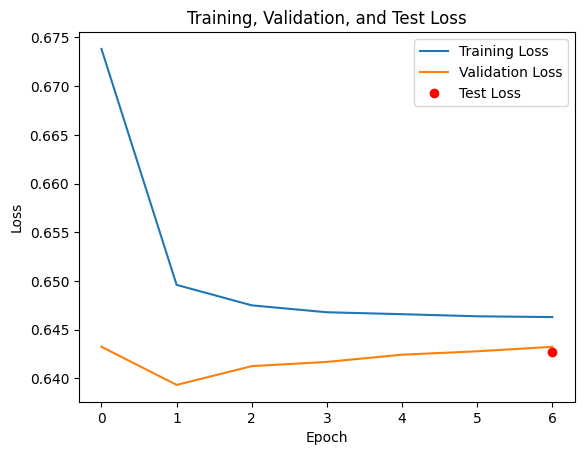

In [54]:
# Plot the training, validation, and test loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(len(history.history['loss']) - 1, test_loss, 'ro', label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()

#### Predict

In [106]:
test_instance = next(iter(test_read.map(prep_batch).batch(2).take(1)))[0] # get first element of tuple for prediction
test_instance

<tf.Tensor: shape=(2, 30), dtype=float64, numpy=
array([[ 4.33300000e+04, -1.51030791e+00,  7.80683602e-01,
         2.08574736e+00,  3.12313283e+00,  5.89556504e-01,
         1.30168094e+00, -1.30099101e+00, -2.34533311e+00,
         1.48722209e-01,  1.06300824e+00, -1.88035726e+00,
         3.10971711e-01,  9.54298638e-01, -1.10646280e+00,
        -7.86015840e-01, -5.55324333e-01,  3.35236557e-01,
         1.85637688e-01,  1.54380629e+00, -6.44864027e-01,
         2.22981820e+00, -4.60620924e-02, -3.41323962e-01,
        -3.70869344e-01, -2.01199298e-01,  4.23963954e-01,
         2.10998182e-01, -5.86163935e-02,  0.00000000e+00],
       [ 1.41955000e+05, -1.58553155e+00,  1.24041103e+00,
        -5.58349101e-01, -8.41657245e-01,  3.97502038e-01,
        -1.53272269e+00,  3.88817678e-01,  5.75896042e-01,
        -2.78369582e-01, -8.56928209e-01, -1.11892547e+00,
         7.37223588e-01,  4.79262560e-01,  7.95002104e-01,
        -3.96344845e-01, -3.62277829e-01,  4.99583980e-02,
      

In [107]:
denormalizer(autoencoder.predict(normalizer(test_instance)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Array([[ 6.78442031e+04, -3.28995109e-01,  1.22358300e-01,
         6.20532990e-01,  2.19555888e-02, -2.18390077e-01,
        -1.68783128e-01, -3.92828286e-02,  7.99054354e-02,
        -9.88100395e-02, -1.20875344e-01,  3.68811376e-02,
         1.39660284e-01,  1.74331591e-02,  2.60786247e-02,
         1.96518883e-01,  9.37388167e-02, -3.49491648e-02,
        -1.41241867e-02, -7.04543060e-03, -3.13049890e-02,
        -5.63311130e-02, -7.85807595e-02, -2.94602849e-02,
         5.29047176e-02,  9.37912017e-02, -6.87602386e-02,
         1.19836284e-02,  2.15235911e-02,  2.37034454e+01],
       [ 1.09510266e+05,  2.29332015e-01,  3.61228958e-02,
        -2.72302032e-01, -1.14036068e-01,  4.89010885e-02,
        -3.35452795e-01,  7.21692815e-02, -2.99641816e-03,
         1.06096845e-02, -8.19130465e-02, -8.25194567e-02,
         1.49689600e-01, -2.30007265e-02,  6.32765144e-02,
        -3.89189720e-02,  8.06107372e-02, -1.00753196e-01,
         1.72823165e-02, -4.35313070e-03, -8.05594102e-

In [113]:
denormalized_inputs[0]

Array([ 2.0586915e+09, -2.9067321e+00,  1.2707657e+00,  3.0506668e+00,
        4.3647976e+00,  7.9704833e-01,  1.7216213e+00, -1.4941536e+00,
       -2.7311628e+00,  1.6718908e-01,  1.1177402e+00, -1.8942933e+00,
        3.0519766e-01,  9.4831055e-01, -9.8183954e-01, -7.1925813e-01,
       -4.6220097e-01,  2.6503190e-01,  1.5644884e-01,  1.2524958e+00,
       -4.8806030e-01,  1.5977783e+00, -3.3635538e-02, -2.1208468e-01,
       -2.2477910e-01, -1.0579545e-01,  2.0509705e-01,  8.2467936e-02,
       -1.9380482e-02,  8.7892921e+01], dtype=float32)

#### Visualize Reconstructions

Original Data Units:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


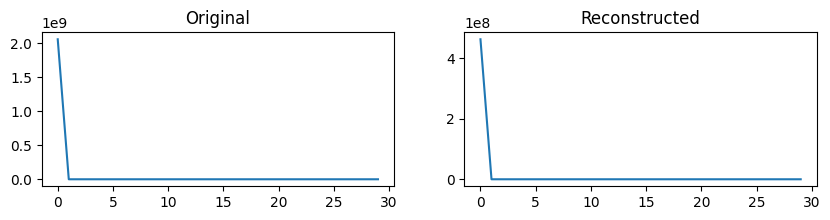

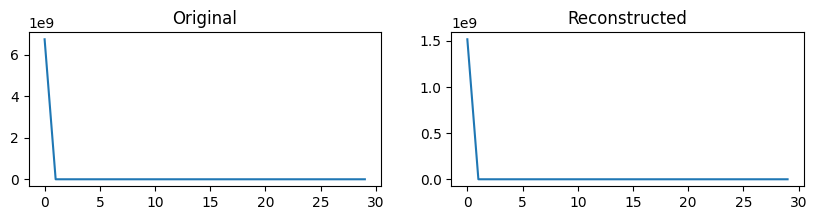

In [114]:
reconstructions = autoencoder.predict(test_instance)
denormalized_inputs = denormalizer(test_instance)
denormalized_reconstructions = denormalizer(reconstructions)

for i in range(test_instance.shape[0]):
    plt.figure(figsize=(10, 2))

    plt.subplot(1, 2, 1)
    plt.plot(denormalized_inputs[i])  # Original
    plt.title('Original')

    plt.subplot(1, 2, 2)
    plt.plot(denormalized_reconstructions[i])  # Reconstructed
    plt.title('Reconstructed')

    plt.show()

Normalized Data:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


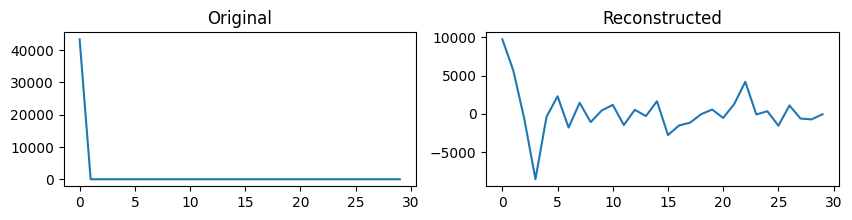

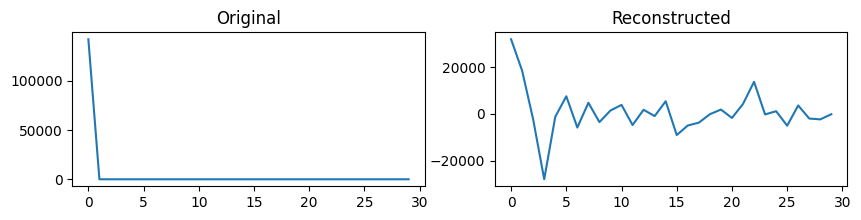

In [116]:
reconstructions = autoencoder.predict(test_instance)

for i in range(test_instance.shape[0]):
    plt.figure(figsize=(10, 2))

    plt.subplot(1, 2, 1)
    plt.plot(test_instance[i])  # Original
    plt.title('Original')

    plt.subplot(1, 2, 2)
    plt.plot(reconstructions[i])  # Reconstructed
    plt.title('Reconstructed')

    plt.show()

---
## Enchance Autoencoder

### Combine Preprocessing, Model, and Postprocessing

With Keras models can be layers in new models.  Here a new model combines the preprocessing layers, normalizer and denormalizer, with the autoencoder into a new model object we will call a stacked model.

#### Stacked Model

In [58]:
type(normalizer), type(autoencoder), type(denormalizer)

(keras.src.layers.preprocessing.normalization.Normalization,
 keras.src.models.functional.Functional,
 keras.src.layers.preprocessing.normalization.Normalization)

In [59]:
# Create a new sequential model
stacked_model = keras.Sequential([
    normalizer,
    autoencoder,
    denormalizer
], name='stacked_autoencoder')

#### Predict

In [64]:
test_instance = next(iter(test_read.map(prep_batch).batch(3).take(1)))[0]
test_instance

<tf.Tensor: shape=(3, 30), dtype=float64, numpy=
array([[ 4.33300000e+04, -1.51030791e+00,  7.80683602e-01,
         2.08574736e+00,  3.12313283e+00,  5.89556504e-01,
         1.30168094e+00, -1.30099101e+00, -2.34533311e+00,
         1.48722209e-01,  1.06300824e+00, -1.88035726e+00,
         3.10971711e-01,  9.54298638e-01, -1.10646280e+00,
        -7.86015840e-01, -5.55324333e-01,  3.35236557e-01,
         1.85637688e-01,  1.54380629e+00, -6.44864027e-01,
         2.22981820e+00, -4.60620924e-02, -3.41323962e-01,
        -3.70869344e-01, -2.01199298e-01,  4.23963954e-01,
         2.10998182e-01, -5.86163935e-02,  0.00000000e+00],
       [ 1.41955000e+05, -1.58553155e+00,  1.24041103e+00,
        -5.58349101e-01, -8.41657245e-01,  3.97502038e-01,
        -1.53272269e+00,  3.88817678e-01,  5.75896042e-01,
        -2.78369582e-01, -8.56928209e-01, -1.11892547e+00,
         7.37223588e-01,  4.79262560e-01,  7.95002104e-01,
        -3.96344845e-01, -3.62277829e-01,  4.99583980e-02,
      

In [65]:
stacked_model.predict(test_instance)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[ 6.78442109e+04, -3.28995109e-01,  1.22358300e-01,
         6.20533049e-01,  2.19555888e-02, -2.18390077e-01,
        -1.68783128e-01, -3.92828248e-02,  7.99054354e-02,
        -9.88100395e-02, -1.20875344e-01,  3.68811339e-02,
         1.39660284e-01,  1.74331609e-02,  2.60786247e-02,
         1.96518868e-01,  9.37388167e-02, -3.49491648e-02,
        -1.41241876e-02, -7.04543060e-03, -3.13049890e-02,
        -5.63311130e-02, -7.85807669e-02, -2.94602849e-02,
         5.29047176e-02,  9.37912092e-02, -6.87602460e-02,
         1.19836284e-02,  2.15235911e-02,  2.37034473e+01],
       [ 1.09510266e+05,  2.29332075e-01,  3.61229032e-02,
        -2.72302061e-01, -1.14036061e-01,  4.89010885e-02,
        -3.35452795e-01,  7.21692815e-02, -2.99642677e-03,
         1.06096836e-02, -8.19130465e-02, -8.25194567e-02,
         1.49689600e-01, -2.30007228e-02,  6.32765144e-02,
        -3.89189720e-02,  8.06107298e-02, -1.00753196e-01,
         1.72823165e-02, -4.35313070e-03, -8.05594102e-

#### Review The Model

In [66]:
stacked_model.summary()

Model: "stacked_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (3, 30)                │            61 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ autoencoder (Functional)        │ (3, 30)                │         1,362 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denormalize (Normalization)     │ (3, 30)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,423 (5.56 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 61 (244.00 B)

In [67]:
stacked_model.summary(expand_nested=True)

Model: "stacked_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (3, 30)                │            61 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ autoencoder (Functional)        │ (3, 30)                │         1,362 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ autoencoder_input          │ (None, 30)             │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ enc_dense1 (Dense)         │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ enc_dropout1 (Dropout)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ enc_dense2 (Dense)         │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ enc_dropout2 (Dropout)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ latent (Dense)             │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dec_dense1 (Dense)         │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dec_dropout1 (Dropout)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dec_dense2 (Dense)         │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dec_dropout2 (Dropout)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ reconstructed (Dense)      │ (None, 30)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denormalize (Normalization)     │ (3, 30)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,423 (5.56 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 61 (244.00 B)

### Adding Named Inputs

How can we prevent feature order drift?  How about modifying the input to receive a dictionary of key:value pairs that map to the correct order inside the model!

Named inputs, a dictionary of features
- input dictionary, concatenate features, pass to the stacked model

Why?
- user-friendly!
- prevent training serving skew from feature order drift causing serving error


Using an ordered dictionary for the input layers ensures the inputs order as they pass to the concatenation layers is consistent.  The inputs to the model can actually be out of order but this ordering of the input layer will force the consistency needed.

#### Input Layer

In [117]:
input_dict = OrderedDict()
for key in var_numeric:
    input_dict[key] = keras.layers.Input(shape=(1,), name=key)

In [69]:
concatenated_inputs = keras.layers.Concatenate(axis = -1)(list(input_dict.values()))

#### Model

In [70]:
ordered_model = keras.Model(inputs = input_dict, outputs = stacked_model(concatenated_inputs))

#### Data Mapping

In [122]:
def prep_batch_ordered(source):
    for k in var_omit + var_target:
        source.pop(k, None)
        
    #Check the keys
    if set(source.keys()) != set(var_numeric):
        raise ValueError("Input data keys do not match expected feature names.")

    return OrderedDict((key, source[key]) for key in var_numeric)    

In [123]:
test_instance = next(iter(test_read.map(prep_batch_ordered).batch(3).take(1)))

#### Predict

In [124]:
ordered_model.predict(test_instance)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([[ 6.78442109e+04, -3.28995109e-01,  1.22358300e-01,
         6.20533049e-01,  2.19555888e-02, -2.18390077e-01,
        -1.68783128e-01, -3.92828248e-02,  7.99054354e-02,
        -9.88100395e-02, -1.20875344e-01,  3.68811339e-02,
         1.39660284e-01,  1.74331609e-02,  2.60786247e-02,
         1.96518868e-01,  9.37388167e-02, -3.49491648e-02,
        -1.41241876e-02, -7.04543060e-03, -3.13049890e-02,
        -5.63311130e-02, -7.85807669e-02, -2.94602849e-02,
         5.29047176e-02,  9.37912092e-02, -6.87602460e-02,
         1.19836284e-02,  2.15235911e-02,  2.37034473e+01],
       [ 1.09510266e+05,  2.29332075e-01,  3.61229032e-02,
        -2.72302061e-01, -1.14036061e-01,  4.89010885e-02,
        -3.35452795e-01,  7.21692815e-02, -2.99642677e-03,
         1.06096836e-02, -8.19130465e-02, -8.25194567e-02,
         1.49689600e-01, -2.30007228e-02,  6.32765144e-02,
        -3.89189720e-02,  8.06107298e-02, -1.00753196e-01,
         1.72823165e-02, -4.35313070e-03, -8.05594102e-

In [125]:
test_instance

OrderedDict([('Time',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 43330., 141955.,  58813.])>),
             ('V1',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-1.51030791, -1.58553155, -2.52434169])>),
             ('V2',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 0.7806836 ,  1.24041103, -0.3137836 ])>),
             ('V3',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 2.08574736, -0.5583491 ,  2.30408519])>),
             ('V4',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 3.12313283, -0.84165725,  3.04301624])>),
             ('V5',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.5895565 , 0.39750204, 5.49568553])>),
             ('V6',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 1.30168094, -1.53272269, -2.60034741])>),
             ('V7',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-1.30099101,  0.38881768

#### Review The Model

In [126]:
ordered_model.summary(expand_nested = True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Time (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V1 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V2 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V3 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V4 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V5 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V6 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V7 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V8 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V9 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V10 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V11 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V12 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V13 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V14 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V15 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V16 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V17 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V18 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V19 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V20 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V21 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V22 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V23 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V24 (InputLayer)    │ (None, 1)         │          0 │ -               

 Total params: 1,423 (5.56 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 61 (244.00 B)

### Adding Detailed Outputs

In [163]:
class NormalizedMetricsLayer(keras.layers.Layer):
    def __init__(self, normalizer, name='normalized_metrics'):
        super(NormalizedMetricsLayer, self).__init__(name=name)
        self.normalizer = normalizer
        self.mae = keras.metrics.MeanAbsoluteError()
        self.rmse = keras.metrics.RootMeanSquaredError()
        self.mse = keras.metrics.MeanSquaredError()
        self.msle = keras.metrics.MeanSquaredLogarithmicError()

    def call(self, inputs, targets):
        normalized_inputs = self.normalizer(inputs)
        self.mae.update_state(normalized_inputs, targets)
        self.rmse.update_state(normalized_inputs, targets)
        self.mse.update_state(normalized_inputs, targets)
        self.msle.update_state(normalized_inputs, targets)

        return {
            'MAE': self.mae.result(),
            'RMSE': self.rmse.result(),
            'MSE': self.mse.result(),
            'MSLE': self.msle.result()
        }

In [164]:
class DenormalizedOutputsLayer(keras.layers.Layer):
    def __init__(self, denormalizer, name='denormalized_outputs'):
        super(DenormalizedOutputsLayer, self).__init__(name=name)
        self.denormalizer = denormalizer

    def call(self, inputs, targets):
        denormalized_inputs = self.denormalizer(inputs)
        denormalized_targets = self.denormalizer(targets)
        errors = denormalized_inputs - denormalized_targets

        return {
            'reconstruction': denormalized_targets,
            'reconstruction_errors': errors
        }

In [165]:
# Get the normalized predictions from the stacked autoencoder
normalized_predictions = stacked_model(concatenated_inputs)

# Calculate normalized metrics
normalized_metrics = NormalizedMetricsLayer(normalizer)(concatenated_inputs, normalized_predictions)

# Calculate denormalized outputs
denormalized_outputs = DenormalizedOutputsLayer(denormalizer)(concatenated_inputs, normalized_predictions)

In [166]:
# Create the final model
final_model = keras.Model(
    inputs=input_dict,
    outputs={
        'normalized': {
            'reconstruction': normalized_predictions,
            'reconstruction_errors': concatenated_inputs - normalized_predictions,
            'metrics': normalized_metrics
        },
        'denormalized': denormalized_outputs
    },
    name='final_model'
)

In [167]:
def prep_batch_ordered(source):
    for k in var_omit + var_target:
        source.pop(k, None)
        
    #Check the keys
    if set(source.keys()) != set(var_numeric):
        raise ValueError("Input data keys do not match expected feature names.")

    return OrderedDict((key, source[key]) for key in var_numeric)

In [168]:
test_instance = next(iter(test_read.batch(3).take(1).map(prep_batch_dict)))

In [172]:
test_instance

OrderedDict([('Time',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 43330., 141955.,  58813.])>),
             ('V1',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-1.51030791, -1.58553155, -2.52434169])>),
             ('V2',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 0.7806836 ,  1.24041103, -0.3137836 ])>),
             ('V3',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 2.08574736, -0.5583491 ,  2.30408519])>),
             ('V4',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 3.12313283, -0.84165725,  3.04301624])>),
             ('V5',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.5895565 , 0.39750204, 5.49568553])>),
             ('V6',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 1.30168094, -1.53272269, -2.60034741])>),
             ('V7',
              <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-1.30099101,  0.38881768

In [170]:
predictions = final_model.predict(test_instance)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


ValueError: zero-dimensional arrays cannot be concatenated

In [171]:
final_model.summary(expand_nested = True)

Model: "final_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Time (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V1 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V2 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V3 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V4 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V5 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V6 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V7 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V8 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V9 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V10 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V11 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V12 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V13 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V14 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V15 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V16 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V17 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V18 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V19 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V20 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V21 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V22 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V23 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V24 (InputLayer)    │ (None, 1)         │          0 │ -               

 Total params: 1,423 (5.56 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 61 (244.00 B)

## Model Saving And Serving

At serving use the models input signature to define a prep_batch_dict function with the correct ordered dictionary.

---
## WIP

---
Customizing the outputs:
    - reconstructed values: normalized, denormalized
    - errors in reconstructed values: normalized, denormalized
    - embedding layer
    - error metrics: MAE, MSE, RMSE    

In [63]:
# Get encoder output
encoder_output = autoencoder.get_layer('enc_dense3').output

In [66]:
# L2 normalize the embedding using Lambda layer with output_shape
normalized_embedding = keras.layers.Lambda(
    lambda x: x / tf.sqrt(tf.reduce_sum(tf.square(x), axis=-1, keepdims=True)),
    output_shape=lambda input_shape: input_shape
)(encoder_output)

In [67]:
# Connect the concatenated inputs to the stacked model
denormalized_output = stacked_model(concatenated_inputs)

In [70]:
# Create outputs for the model
normalized_reconstruction = autoencoder(concatenated_inputs)
denormalized_reconstruction = denormalized_output
# Calculate reconstruction errors using Lambda layers and TensorFlow operations
normalized_reconstruction_error = keras.layers.Lambda(
    lambda x: tf.abs(x[0] - x[1]),
    output_shape=lambda input_shape: input_shape[0]
)([concatenated_inputs, normalized_reconstruction])
denormalized_reconstruction_error = keras.layers.Lambda(
    lambda x: tf.abs(x[0] - x[1]),
    output_shape=lambda input_shape: input_shape[0]
)([denormalizer(concatenated_inputs), denormalized_reconstruction])

In [71]:
# Create the final model with structured output
final_model = keras.Model(
    inputs=input_dict,
    outputs={
        'reconstruction': {
            'normalized': normalized_reconstruction,
            'denormalized': denormalized_reconstruction,
        },
        'reconstruction_errors': {
            'normalized': normalized_reconstruction_error,
            'denormalized': denormalized_reconstruction_error,
        },
        'embedding': {
            'encoding': encoder_output,
            'normalized_encoding': normalized_embedding,
        }
    }
)

In [72]:
test_instance = next(iter(test_read.map(prep_batch_dict).batch(3).take(1)))

In [73]:
final_model.predict(test_instance)

AttributeError: 'str' object has no attribute '_error_repr'

In [75]:
# 1. Prepare a Single Batch with Correct Structure
test_read_dict = test_read.map(prep_batch_dict)
test_batch = next(iter(test_read_dict.batch(3)))  # No need for .take(1)

# Access the dictionary (first element of the tuple)
test_instance_dict = test_batch

# 2. Perform Prediction
predictions = final_model.predict(test_instance_dict)

TypeError: 'NoneType' object is not callable

Notes:
- outputs customized
- more epochs but using the full model
    - or the inner model - how does it update the full
- specific
    - rename middle layer: embedding
    - output normalized version of this
- export/import example
- for dict input convert test instance to actual dictionary:
    - show inference
    - show mis-ordered inference
    - add extra keys, show inference
- supervised (maybe another workflow)
- semi-superfixed with pre-train and fine-tune (maybe another workflow)
- vae (another workflow)
- serving with continual/incrmental learning using mini batch update
- pipeline to train - include experiments, artifacts
    - set hyperparamters
    - train in component
    - train as training job
    - hyperparameter tuning to find best paramters with vizier.  Prepfer pipeline and direct api usage if possible.
- build autoencoder variations
    - fine tune as semi-supervised
    - fine tune as vae
    - fine tune as semi-supervised vae
- introduce timeseries autoencoder
    - fine tune as transformer using rows/time/series as sequence